In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_distances
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from tqdm import tqdm

Loading IndoBERT model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Model loaded on: cpu

Loading corpus files...
Loaded 2022: 32364536 characters
Loaded 2023: 27897348 characters
Loaded 2024: 34778762 characters
Loaded 2025: 31717824 characters

Extracting target vocabulary from all corpora...
Target vocabulary size: 48 terms
Sample terms: ['buruh', 'saat', 'tersebut', 'vaksin', 'jokowi', 'impor', 'koalisi', 'kabar', 'ganjar', 'bbm']

COMPUTING WORD-LEVEL TEMPORAL EMBEDDINGS


Extracting embeddings: 100%|██████████| 48/48 [2:00:01<00:00, 150.04s/it]



Calculating semantic drift for each word...

Computing corpus-level drift (baseline comparison)...
Generating corpus embedding for 2022...
Generating corpus embedding for 2023...
Generating corpus embedding for 2024...
Generating corpus embedding for 2025...

Computing drift threshold (τ) from corpus variance...
Baseline intra-year variance: 0.2084
Drift threshold (τ): 0.3033

Generating visualizations...
Saved: corpus_drift_heatmap.png
Saved: top_drifting_words.png
Saved: temporal_trajectory_pca.png

Generating t-SNE visualization...
Saved: semantic_clusters_tsne.png

Saving results...
Saved: word_level_temporal_drift.csv
Saved: corpus_level_drift_matrix.csv
Saved: drift_analysis_summary.txt

ANALYSIS COMPLETE

 CORPUS-LEVEL DRIFT MATRIX:
          2022      2023      2024      2025
2022  0.000000  0.311018  0.091164  0.156246
2023  0.311018  0.000000  0.322773  0.376532
2024  0.091164  0.322773  0.000000  0.210128
2025  0.156246  0.376532  0.210128  0.000000

 TOP 10 WORDS WITH HIGH

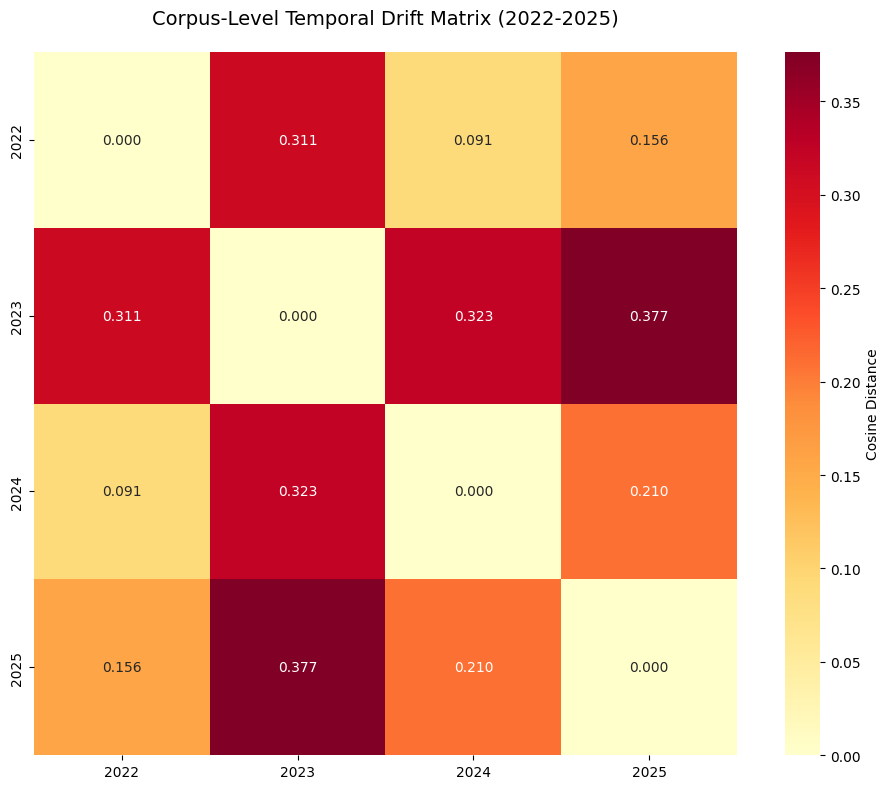

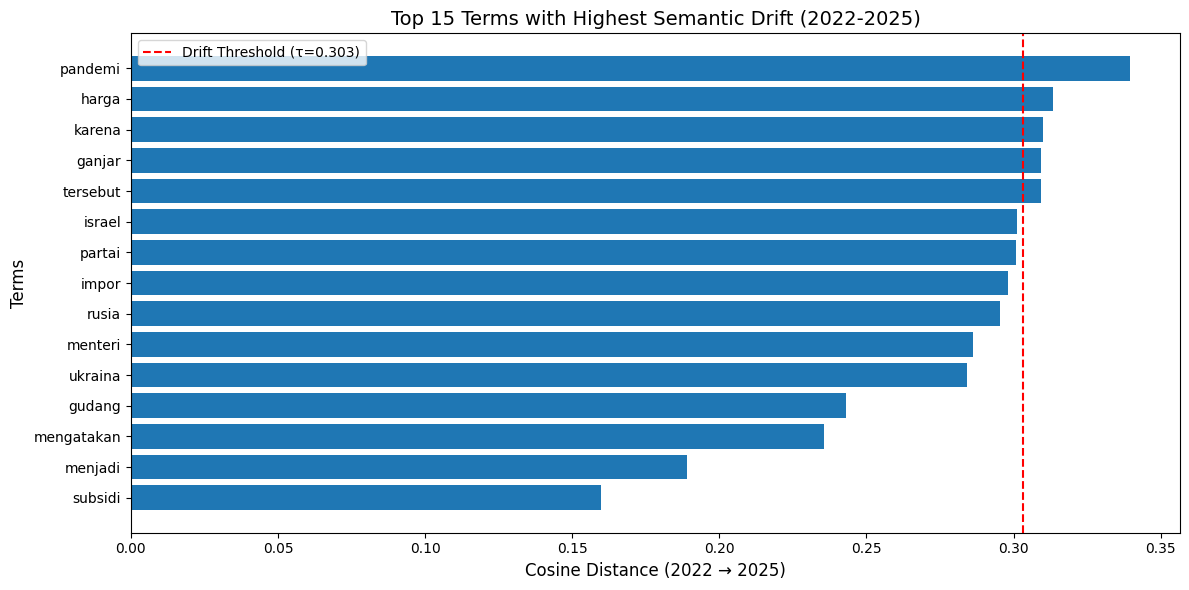

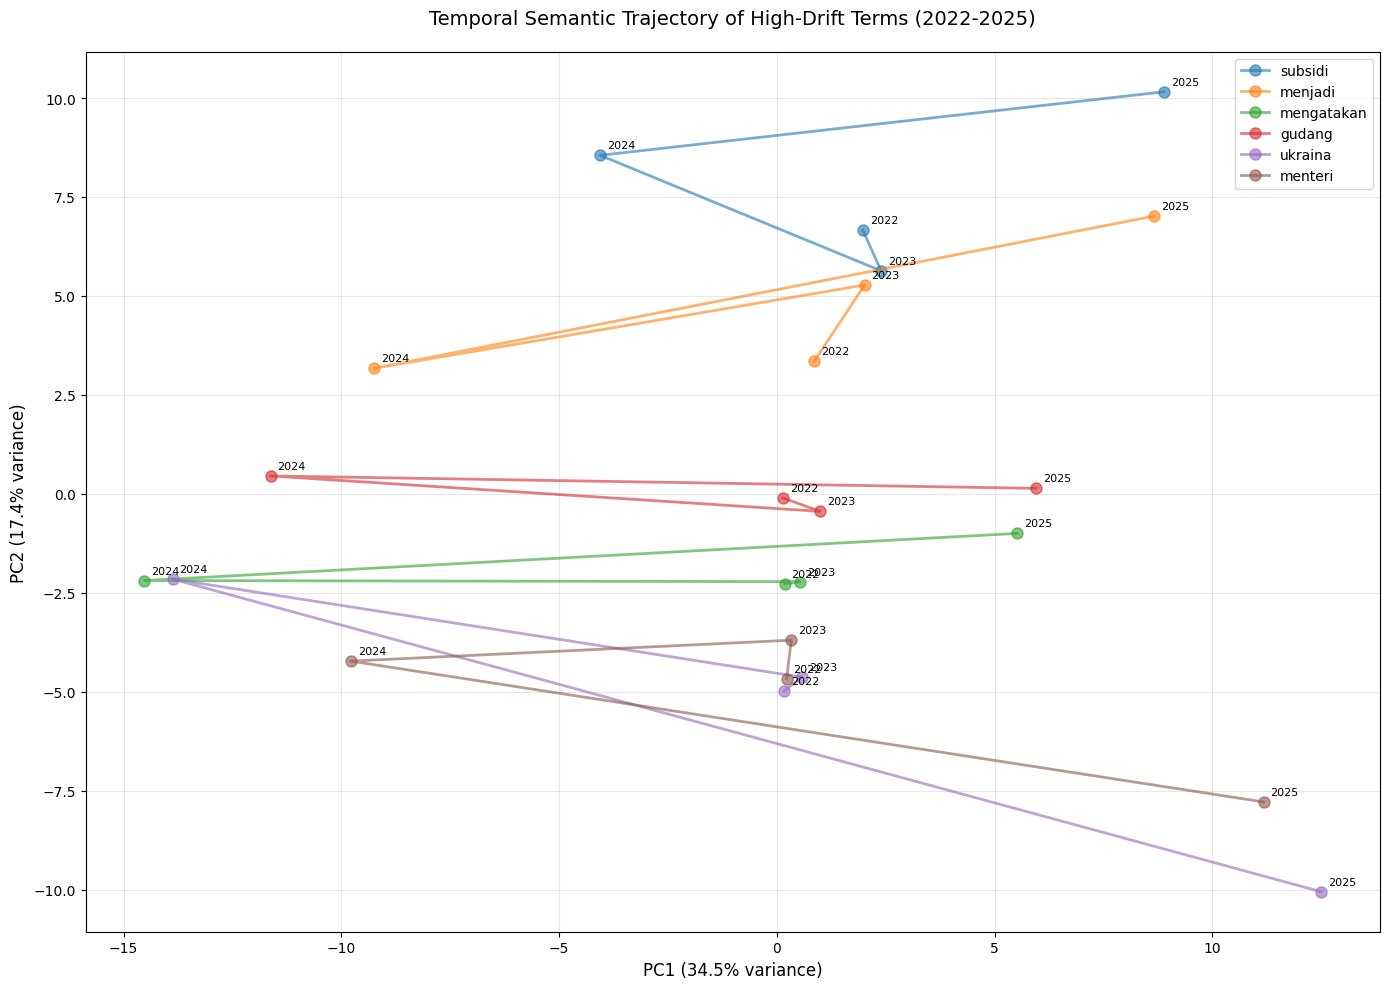

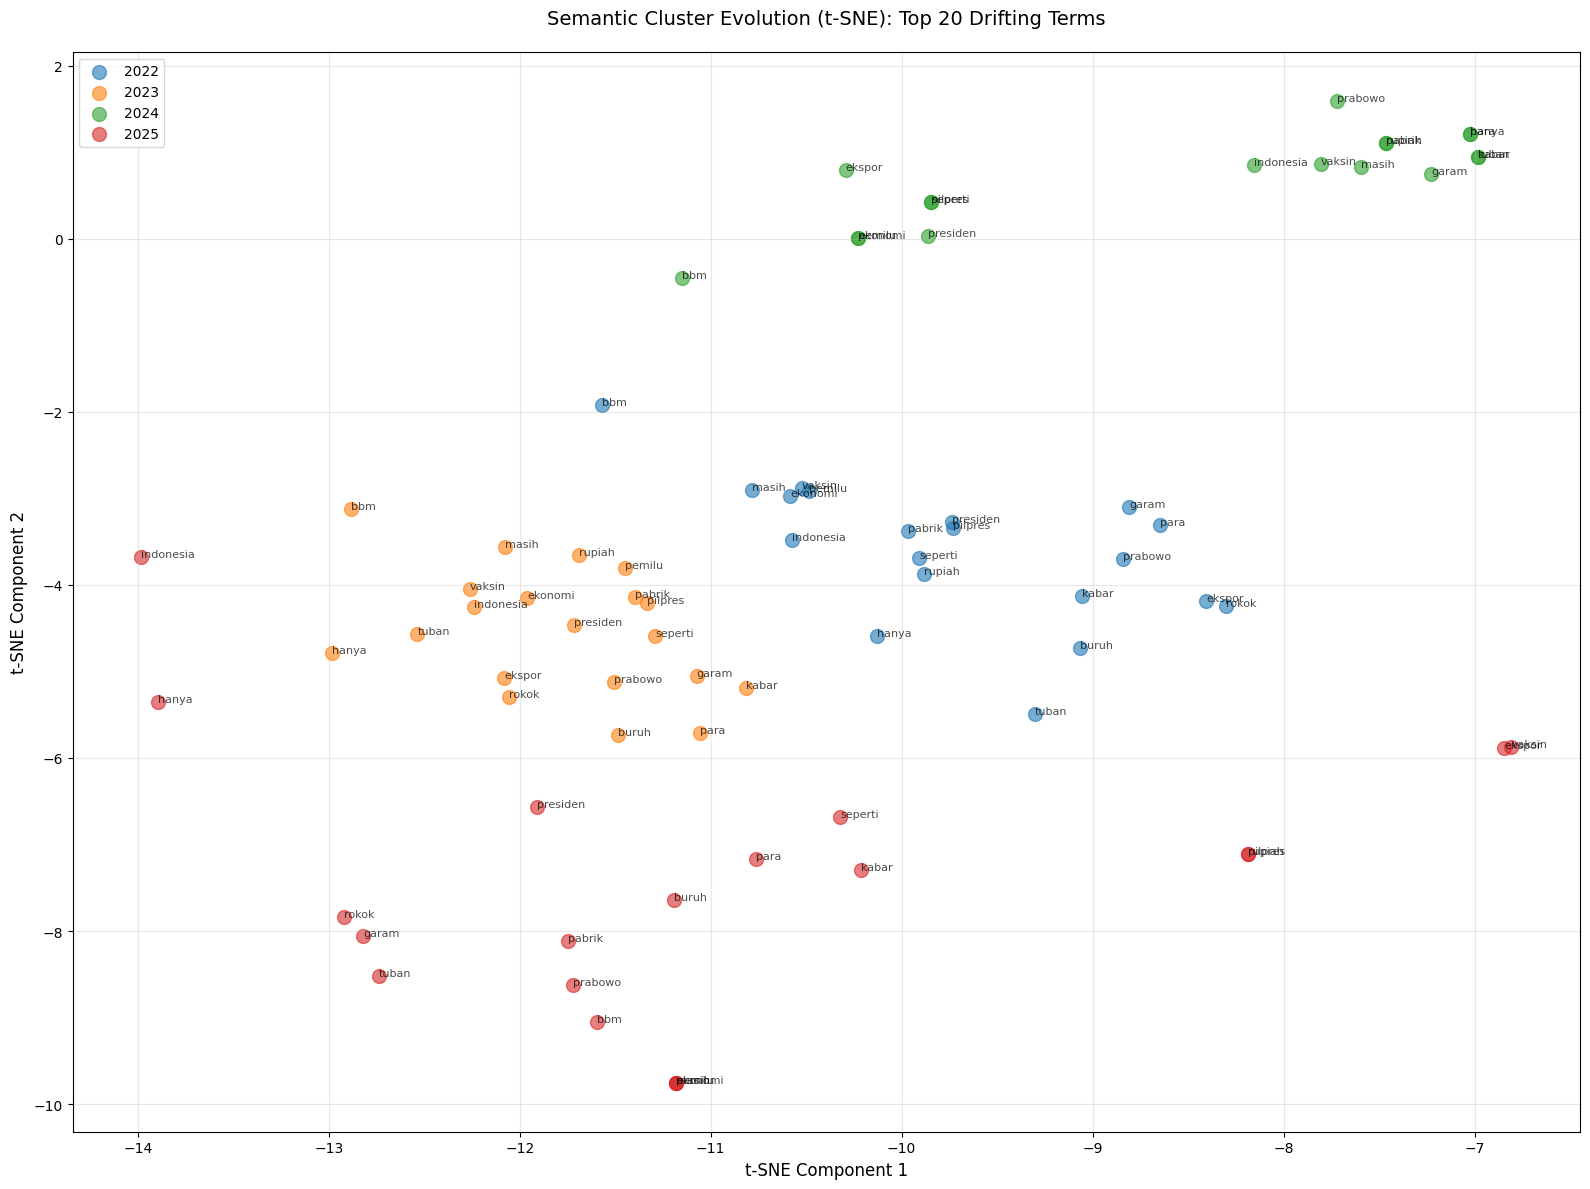

In [ ]:

# ============================
# 1. LOAD INDOBERT MODEL
# ============================
print("Loading IndoBERT model...")
model_name = "indobenchmark/indobert-base-p1"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print(f"Model loaded on: {device}")

# ============================
# 2. WORD-LEVEL EMBEDDING EXTRACTION
# ============================
def get_word_embedding_in_context(word, corpus, tokenizer, model, max_samples=50):
    """
    Extract contextual embedding untuk kata spesifik dari berbagai konteks di korpus.
    Mengikuti metodologi Hamilton et al. untuk diachronic embeddings.
    """
    sentences = []

    # Split corpus menjadi kalimat
    corpus_sentences = re.split(r'[.!?]+', corpus)

    # Ekstrak kalimat yang mengandung kata target
    for sent in corpus_sentences:
        sent = sent.strip()
        if len(sent) > 10 and word.lower() in sent.lower():
            sentences.append(sent)
            if len(sentences) >= max_samples:
                break

    if not sentences:
        return None

    embeddings = []

    for sent in sentences:
        try:
            # Tokenize
            inputs = tokenizer(
                sent,
                return_tensors="pt",
                truncation=True,
                max_length=256,
                padding=True
            )

            # Get tokens
            tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

            # Cari indeks kata target (handle subword tokenization)
            target_indices = []
            for i, tok in enumerate(tokens):
                # Remove special tokens dan symbols
                clean_tok = tok.replace('##', '').replace('▁', '').lower()
                if word.lower() in clean_tok or clean_tok in word.lower():
                    target_indices.append(i)

            if target_indices:
                with torch.no_grad():
                    outputs = model(**inputs.to(device))

                # Average embeddings dari semua posisi kata target dalam kalimat ini
                sent_embeddings = []
                for idx in target_indices:
                    if idx < outputs.last_hidden_state.shape[1]:
                        sent_embeddings.append(
                            outputs.last_hidden_state[0, idx].cpu()
                        )

                if sent_embeddings:
                    embeddings.append(torch.stack(sent_embeddings).mean(dim=0))

        except Exception as e:
            continue

    if embeddings:
        # Average across all contexts untuk kata ini di periode ini
        return torch.stack(embeddings).mean(dim=0)

    return None

# ============================
# 3. ENTITY EXTRACTION
# ============================
def extract_entities_and_keywords(corpus, top_n=30):
    """
    Extract entitas dan kata kunci paling sering dari korpus.
    Ini akan menjadi vocabulary target untuk temporal drift analysis.
    """
    # Simple entity extraction: kapitalisasi + frequency
    words = re.findall(r'\b[A-Z][a-z]+\b', corpus)

    # Common words frequency
    all_words = re.findall(r'\b[a-z]{4,}\b', corpus.lower())

    entity_freq = Counter(words)
    word_freq = Counter(all_words)

    # Filter stopwords sederhana
    indonesian_stopwords = {'yang', 'untuk', 'pada', 'dengan', 'dari', 'akan',
                           'oleh', 'dalam', 'tidak', 'ini', 'itu', 'adalah',
                           'juga', 'telah', 'atau', 'dapat', 'sebagai','kepada',
                           'bahwa','lebih','bisa','kata'}

    filtered_words = {w: c for w, c in word_freq.items()
                     if w not in indonesian_stopwords and c > 5}

    top_entities = [w for w, _ in entity_freq.most_common(top_n//2)]
    top_words = [w for w, _ in sorted(filtered_words.items(),
                                      key=lambda x: x[1],
                                      reverse=True)[:top_n//2]]

    return list(set(top_entities + top_words))

# ============================
# 4. READ CORPUS FILES
# ============================
print("\nLoading corpus files...")
files = {
    "2022": "2022.txt",
    "2023": "2023.txt",
    "2024": "2024.txt",
    "2025": "2025.txt"
}

corpus = {}
for year, filepath in files.items():
    try:
        with open(filepath, "r", encoding="utf-8") as f:
            corpus[year] = f.read()
        print(f"Loaded {year}: {len(corpus[year])} characters")
    except FileNotFoundError:
        print(f"Warning: {filepath} not found!")

years = list(corpus.keys())

# ============================
# 5. EXTRACT TARGET VOCABULARY
# ============================
print("\nExtracting target vocabulary from all corpora...")

# Combine all corpora untuk extract vocabulary
combined_corpus = " ".join(corpus.values())
target_vocabulary = extract_entities_and_keywords(combined_corpus, top_n=40)

# Tambahkan kata-kata domain-specific penting
domain_terms = [
    # Politik
    "pemilu", "presiden", "pilpres", "prabowo", "jokowi", "anies",
    "ganjar", "partai", "koalisi", "menteri",
    # Ekonomi
    "inflasi", "rupiah", "ekonomi", "investasi", "bbm", "subsidi",
    "harga", "ekspor", "impor",
    # Sosial
    "covid", "vaksin", "pandemi", "kesehatan",
    # Regional/Global
    "palestina", "israel", "gaza", "ukraina", "rusia"
]

target_vocabulary = list(set(target_vocabulary + domain_terms))
print(f"Target vocabulary size: {len(target_vocabulary)} terms")
print(f"Sample terms: {target_vocabulary[:10]}")

# ============================
# 6. COMPUTE WORD-LEVEL TEMPORAL EMBEDDINGS
# ============================
print("\n" + "="*60)
print("COMPUTING WORD-LEVEL TEMPORAL EMBEDDINGS")
print("="*60)

word_embeddings = {year: {} for year in years}

for word in tqdm(target_vocabulary, desc="Extracting embeddings"):
    for year in years:
        emb = get_word_embedding_in_context(
            word, corpus[year], tokenizer, model, max_samples=50
        )
        if emb is not None:
            word_embeddings[year][word] = emb

# ============================
# 7. CALCULATE SEMANTIC DRIFT PER WORD
# ============================
print("\nCalculating semantic drift for each word...")

drift_results = []

for word in target_vocabulary:
    # Check apakah word ada di semua periode
    available_years = [y for y in years if word in word_embeddings[y]]

    if len(available_years) < 2:
        continue

    # Calculate drift between consecutive years
    yearly_drifts = {}
    for i in range(len(available_years) - 1):
        y1, y2 = available_years[i], available_years[i+1]

        dist = cosine_distances(
            word_embeddings[y1][word].reshape(1, -1),
            word_embeddings[y2][word].reshape(1, -1)
        )[0][0]

        yearly_drifts[f"{y1}-{y2}"] = dist

    # Calculate overall drift (2022 to 2025 if available)
    if "2022" in available_years and "2025" in available_years:
        overall_drift = cosine_distances(
            word_embeddings["2022"][word].reshape(1, -1),
            word_embeddings["2025"][word].reshape(1, -1)
        )[0][0]
    else:
        overall_drift = None

    result = {
        "word": word,
        "overall_drift_2022_2025": overall_drift,
        "available_years": len(available_years),
        **yearly_drifts
    }

    drift_results.append(result)

# Create DataFrame
df_drift = pd.DataFrame(drift_results)
df_drift = df_drift.sort_values("overall_drift_2022_2025", ascending=False)

# ============================
# 8. COMPUTE CORPUS-LEVEL DRIFT (BASELINE)
# ============================
print("\nComputing corpus-level drift (baseline comparison)...")

def get_corpus_embedding(text, tokenizer, model, max_length=512):
    """Get aggregate embedding for entire corpus"""
    inputs = tokenizer(
        text[:10000],  # Sample first 10k chars
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu()
    return embedding

corpus_embeddings = {}
for year, text in corpus.items():
    print(f"Generating corpus embedding for {year}...")
    corpus_embeddings[year] = get_corpus_embedding(text, tokenizer, model)

# Corpus-level distance matrix
corpus_dist_matrix = []
for y1 in years:
    row = []
    for y2 in years:
        d = cosine_distances(
            corpus_embeddings[y1].reshape(1, -1),
            corpus_embeddings[y2].reshape(1, -1)
        )[0][0]
        row.append(d)
    corpus_dist_matrix.append(row)

df_corpus_drift = pd.DataFrame(corpus_dist_matrix, index=years, columns=years)

# ============================
# 9. DETERMINE DRIFT THRESHOLD
# ============================
# Compute intra-year variance as baseline for drift threshold (τ)
print("\nComputing drift threshold (τ) from corpus variance...")

intra_year_variance = []
for year in years:
    words_in_year = list(word_embeddings[year].keys())
    if len(words_in_year) >= 10:
        sample_words = np.random.choice(words_in_year, 10, replace=False)
        distances = []
        for i in range(len(sample_words)):
            for j in range(i+1, len(sample_words)):
                dist = cosine_distances(
                    word_embeddings[year][sample_words[i]].reshape(1, -1),
                    word_embeddings[year][sample_words[j]].reshape(1, -1)
                )[0][0]
                distances.append(dist)
        intra_year_variance.append(np.mean(distances))

baseline_variance = np.mean(intra_year_variance)
drift_threshold = baseline_variance + np.std(intra_year_variance)

print(f"Baseline intra-year variance: {baseline_variance:.4f}")
print(f"Drift threshold (τ): {drift_threshold:.4f}")

# Flag significant drift
df_drift['significant_drift'] = df_drift['overall_drift_2022_2025'] > drift_threshold

# ============================
# 10. VISUALIZATION: HEATMAP
# ============================
print("\nGenerating visualizations...")

plt.figure(figsize=(10, 8))
sns.heatmap(df_corpus_drift, annot=True, fmt='.3f', cmap='YlOrRd',
            square=True, cbar_kws={'label': 'Cosine Distance'})
plt.title('Corpus-Level Temporal Drift Matrix (2022-2025)', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('corpus_drift_heatmap.png', dpi=300, bbox_inches='tight')
print("Saved: corpus_drift_heatmap.png")

# ============================
# 11. VISUALIZATION: TOP DRIFTING WORDS
# ============================
top_drifting = df_drift.nsmallest(15, 'overall_drift_2022_2025')

plt.figure(figsize=(12, 6))
plt.barh(top_drifting['word'], top_drifting['overall_drift_2022_2025'])
plt.xlabel('Cosine Distance (2022 → 2025)', fontsize=12)
plt.ylabel('Terms', fontsize=12)
plt.title('Top 15 Terms with Highest Semantic Drift (2022-2025)', fontsize=14)
plt.axvline(x=drift_threshold, color='red', linestyle='--',
            label=f'Drift Threshold (τ={drift_threshold:.3f})')
plt.legend()
plt.tight_layout()
plt.savefig('top_drifting_words.png', dpi=300, bbox_inches='tight')
print("Saved: top_drifting_words.png")

# ============================
# 12. VISUALIZATION: TEMPORAL TRAJECTORY (PCA)
# ============================
# Select top 6 drifting words for trajectory visualization
trajectory_words = df_drift.nsmallest(6, 'overall_drift_2022_2025')['word'].tolist()

all_embeddings = []
labels = []
colors_map = {'2022': 'blue', '2023': 'green', '2024': 'orange', '2025': 'red'}

for word in trajectory_words:
    for year in years:
        if word in word_embeddings[year]:
            all_embeddings.append(word_embeddings[year][word].numpy())
            labels.append((word, year))

# PCA dimension reduction
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(np.array(all_embeddings))

plt.figure(figsize=(14, 10))

for word in trajectory_words:
    word_data = []
    word_years = []

    for i, (w, y) in enumerate(labels):
        if w == word:
            word_data.append(embeddings_2d[i])
            word_years.append(y)

    if len(word_data) > 1:
        # Plot trajectory
        xs = [p[0] for p in word_data]
        ys = [p[1] for p in word_data]

        plt.plot(xs, ys, marker='o', markersize=8,
                linewidth=2, alpha=0.6, label=word)

        # Annotate years
        for (x, y), year in zip(word_data, word_years):
            plt.annotate(year, (x, y), fontsize=8,
                        xytext=(5, 5), textcoords='offset points')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title('Temporal Semantic Trajectory of High-Drift Terms (2022-2025)',
         fontsize=14, pad=20)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('temporal_trajectory_pca.png', dpi=300, bbox_inches='tight')
print("Saved: temporal_trajectory_pca.png")

# ============================
# 13. VISUALIZATION: t-SNE CLUSTER ANALYSIS
# ============================
print("\nGenerating t-SNE visualization...")

# Sample words untuk cluster analysis
sample_words = df_drift['word'].head(20).tolist()

tsne_embeddings = []
tsne_labels = []

for word in sample_words:
    for year in years:
        if word in word_embeddings[year]:
            tsne_embeddings.append(word_embeddings[year][word].numpy())
            tsne_labels.append((word, year))

if len(tsne_embeddings) > 10:
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(tsne_embeddings)-1))
    embeddings_tsne = tsne.fit_transform(np.array(tsne_embeddings))

    plt.figure(figsize=(16, 12))

    for year in years:
        indices = [i for i, (w, y) in enumerate(tsne_labels) if y == year]
        plt.scatter(embeddings_tsne[indices, 0],
                   embeddings_tsne[indices, 1],
                   label=year, s=100, alpha=0.6)

        # Annotate words
        for idx in indices:
            word = tsne_labels[idx][0]
            plt.annotate(word, (embeddings_tsne[idx, 0], embeddings_tsne[idx, 1]),
                        fontsize=8, alpha=0.7)

    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    plt.title('Semantic Cluster Evolution (t-SNE): Top 20 Drifting Terms',
             fontsize=14, pad=20)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('semantic_clusters_tsne.png', dpi=300, bbox_inches='tight')
    print("Saved: semantic_clusters_tsne.png")

# ============================
# 14. SAVE RESULTS
# ============================
print("\nSaving results...")

# Word-level drift results
df_drift.to_csv("word_level_temporal_drift.csv", index=False)
print("Saved: word_level_temporal_drift.csv")

# Corpus-level drift matrix
df_corpus_drift.to_csv("corpus_level_drift_matrix.csv")
print("Saved: corpus_level_drift_matrix.csv")

# Summary statistics
summary = {
    "total_words_analyzed": len(df_drift),
    "words_with_significant_drift": df_drift['significant_drift'].sum(),
    "drift_threshold": drift_threshold,
    "mean_drift": df_drift['overall_drift_2022_2025'].mean(),
    "median_drift": df_drift['overall_drift_2022_2025'].median(),
    "max_drift": df_drift['overall_drift_2022_2025'].max(),
    "min_drift": df_drift['overall_drift_2022_2025'].min(),
}

with open("drift_analysis_summary.txt", "w") as f:
    f.write("="*60 + "\n")
    f.write("TEMPORAL DRIFT ANALYSIS SUMMARY\n")
    f.write("="*60 + "\n\n")
    for key, value in summary.items():
        f.write(f"{key}: {value}\n")

    f.write("\n" + "="*60 + "\n")
    f.write("TOP 10 DRIFTING TERMS (2022-2025)\n")
    f.write("="*60 + "\n")
    f.write(df_drift[['word', 'overall_drift_2022_2025', 'significant_drift']].head(10).to_string())

    f.write("\n\n" + "="*60 + "\n")
    f.write("CORPUS-LEVEL DRIFT MATRIX\n")
    f.write("="*60 + "\n")
    f.write(df_corpus_drift.to_string())

print("Saved: drift_analysis_summary.txt")

# ============================
# 15. PRINT FINAL RESULTS
# ============================
print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)

print("\n CORPUS-LEVEL DRIFT MATRIX:")
print(df_corpus_drift)

print("\n TOP 10 WORDS WITH HIGHEST SEMANTIC DRIFT (2022-2025):")
print(df_drift[['word', 'overall_drift_2022_2025', 'significant_drift']].head(10))

print("\n SUMMARY STATISTICS:")
for key, value in summary.items():
    print(f"  {key}: {value}")

print("\n All results saved successfully!")
print("\nGenerated files:")
print("  - word_level_temporal_drift.csv")
print("  - corpus_level_drift_matrix.csv")
print("  - drift_analysis_summary.txt")
print("  - corpus_drift_heatmap.png")
print("  - top_drifting_words.png")
print("  - temporal_trajectory_pca.png")
print("  - semantic_clusters_tsne.png")